<h1 style="color:#1F6AE1;">Proceso ETL – Dataset Telco Customer Churn</h1>

En este notebook se realiza el proceso de **extracción, limpieza, transformación y enriquecimiento**
del dataset *Telco Customer Churn*, con el objetivo de preparar los datos para un **problema de
clasificación binaria**: predecir si un cliente causará baja (churn).

El foco principal está en:
- garantizar calidad de los datos,
- mejorar la legibilidad de las variables,
- y crear nuevas características con sentido de negocio.


<h2 style="color:#1F6AE1;">Carga del dataset y exploración inicial</h2>

Se carga el archivo original y se realiza una primera inspección para comprender:
- la dimensión del dataset,
- los tipos de variables,
- y la variable objetivo (`Churn`).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import gc

sns.set_theme(style="whitegrid")


df = pd.read_csv("../csv/Telco-Customer-Churn.csv")

print({df.shape})
df.head()

{(7043, 21)}


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<h2 style="color:#1F6AE1;">Creación de copia de trabajo</h2>

Se crea una copia del dataset original para preservar los datos en bruto y realizar todas
las transformaciones sobre un DataFrame independiente.


In [4]:
df_copy = df.copy()

Visualicación de columnas

In [6]:
# cambia los valores de 'contract' a boolean, donde 'Month-to-month' es False y los demás son True
df_copy["Contract"] = df_copy["Contract"].apply(lambda x: False if x == "Month-to-month" else True)

In [7]:
print()
df_copy.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   bool   
 16  PaperlessBilling  7043 non-null   object 

<h2 style="color:#1F6AE1;">Análisis de valores nulos</h2>

Se visualizan los valores nulos mediante una matriz para identificar posibles problemas
de calidad de datos antes de continuar con las transformaciones.


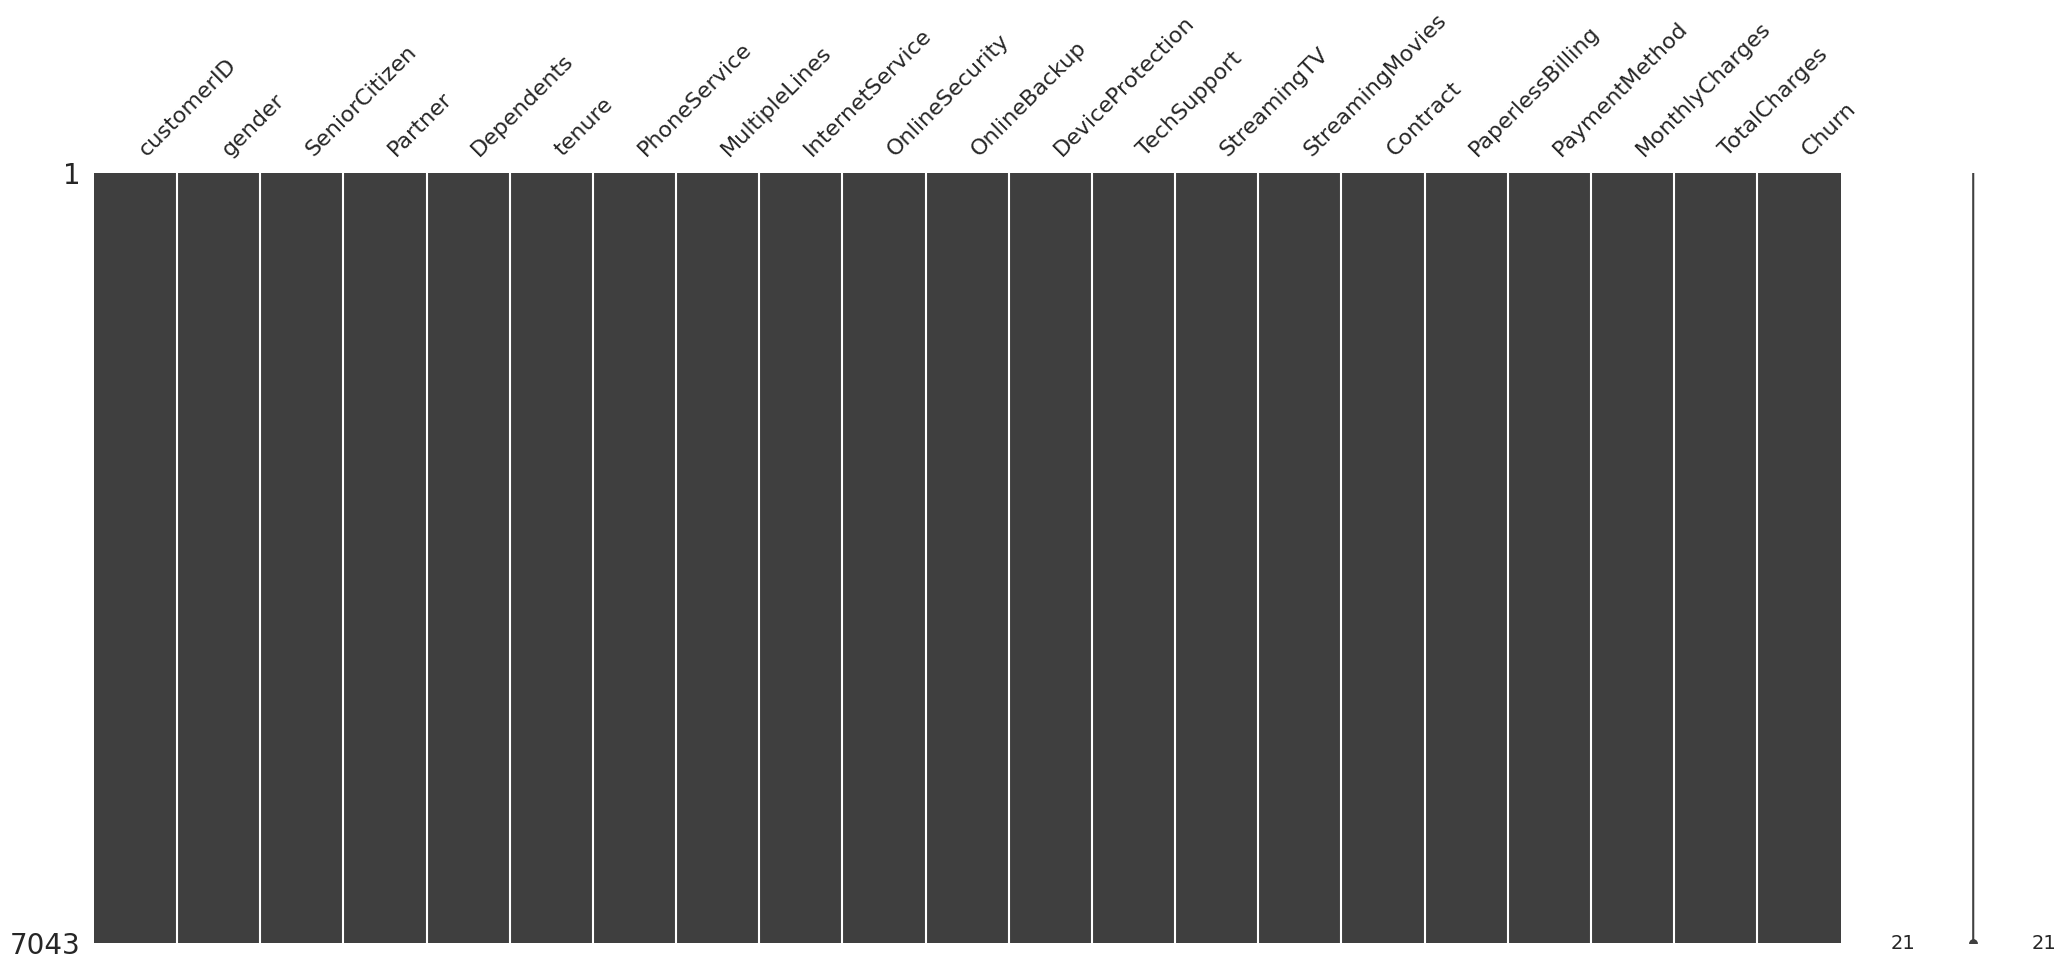

In [8]:
msno.matrix(df_copy)
plt.show()

<h2 style="color:#1F6AE1;">Análisis de variables categóricas</h2>

Se identifican las variables categóricas y se analiza el número de valores únicos de cada una.
Esto permite detectar:
- variables con alta cardinalidad,
- categorías poco frecuentes,
- y posibles transformaciones futuras.


In [9]:
#Varables categóricas df_train
categorical_columns = df_copy.select_dtypes(include=['object']).columns
unique_values = {col: df_copy[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")

gc.collect()

customerID: 7043 unique values
gender: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
TotalCharges: 6531 unique values
Churn: 2 unique values


8481

In [10]:
# muestra los valores únicos de cada columna categórica excepto customerID y TotalCharges
for col in categorical_columns:
    if col not in ['customerID', 'TotalCharges']:
        print(f"{col}: {df_copy[col].unique()}")
        

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


<h2 style="color:#1F6AE1;">Exclusión de variables no informativas del análisis</h2>

La variable `customerID` se excluye del análisis por ser un identificador único sin valor predictivo.
La variable `TotalCharges` se excluye temporalmente debido a que requiere un tratamiento previo
por su formato incorrecto.


In [11]:
categorical_columns = categorical_columns.drop(['customerID', 'TotalCharges'])

for col in categorical_columns:
    print(f"\n{col}")
    print(df[col].value_counts())


gender
gender
Male      3555
Female    3488
Name: count, dtype: int64

Partner
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Dependents
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

PhoneService
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

MultipleLines
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

InternetService
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

OnlineSecurity
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

OnlineBackup
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

DeviceProtection
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

TechSupport
TechSupport
No             

<h2 style="color:#1F6AE1;">Conversión de variables categóricas</h2>

Las variables de tipo texto se convierten a tipo `category` para:
- reducir el consumo de memoria,
- facilitar el posterior encoding,
- y dejar explícita su naturaleza categórica.

In [12]:
# Convertir todas las columnas categóricas a tipo category
for col in categorical_columns:
    df_copy[col] = df_copy[col].astype('category')

# Verificar los cambios
print(df_copy.dtypes)

customerID            object
gender              category
SeniorCitizen          int64
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract                bool
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges          object
Churn               category
dtype: object


In [13]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   int64   
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   bool    
 16  PaperlessBilling  7043 n

Eliminación de la columna `customerID` del dataset

In [14]:
# Eliminar la columna customerID
df_copy = df_copy.drop(columns = 'customerID', axis=1)


<h2 style="color:#1F6AE1;">Limpieza y conversión de "TotalCharges"</h2>


La variable `TotalCharges` contiene valores vacíos que corresponden a clientes
con poca antigüedad. Estos casos se interpretan como clientes en su primer mes,
por lo que se reemplazan por 0.

In [15]:
df_copy['TotalCharges'] = df_copy['TotalCharges'].astype(str).str.strip() 
df_copy['TotalCharges'] = pd.to_numeric(df_copy['TotalCharges'], errors='coerce')
df_copy['TotalCharges'] = df_copy['TotalCharges'].fillna(0)


In [16]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   int64   
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   bool    
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

## Feature Engineering
<h2 style="color:#1F6AE1;">Antigüedad del cliente</h2>

Se crea la variable `cliente_larga_duracion`, que identifica a los clientes con una antigüedad
igual o superior a 24 meses. Esta característica es relevante, ya que clientes con mayor
antigüedad suelen presentar menor probabilidad de churn(abandono).

In [17]:
# Crear columna cliente_larga_duracion

df_copy['cliente_larga_duracion'] = (df_copy['tenure'] >= 24).astype('category')

# Verificar la nueva columna
print(df_copy['cliente_larga_duracion'].value_counts())
print(df_copy[['tenure', 'cliente_larga_duracion']].head(10))

cliente_larga_duracion
True     3927
False    3116
Name: count, dtype: int64
   tenure cliente_larga_duracion
0       1                  False
1      34                   True
2       2                  False
3      45                   True
4       2                  False
5       8                  False
6      22                  False
7      10                  False
8      28                   True
9      62                   True


<h2 style="color:#1F6AE1;">Contratación de múltiples servicios</h2>

Se crea la variable `phone_and_internet`, que indica si el cliente tiene contratados
tanto el servicio de telefonía como el de internet, lo cual puede reflejar mayor
nivel de vinculación con la empresa.

In [18]:
# Crear columna contrato_multiple
df_copy['phone_and_internet'] = ((df_copy['PhoneService'] == 'Yes') & (df_copy['InternetService'] != 'No')).astype('category')

# Verificar la nueva columna
print(df_copy['phone_and_internet'].value_counts())
print(df_copy[['PhoneService', 'InternetService', 'phone_and_internet']].head(10))

phone_and_internet
True     4835
False    2208
Name: count, dtype: int64
  PhoneService InternetService phone_and_internet
0           No             DSL              False
1          Yes             DSL               True
2          Yes             DSL               True
3           No             DSL              False
4          Yes     Fiber optic               True
5          Yes     Fiber optic               True
6          Yes     Fiber optic               True
7           No             DSL              False
8          Yes     Fiber optic               True
9          Yes             DSL               True


Conversión del tipo de `SeniorCitizen` a categórica

In [19]:
df_copy['SeniorCitizen'] = df_copy['SeniorCitizen'].astype('category')

Se especifica que los valores de `SeniorCitizen` sean "noSeniorCitizen" y "SeniorCitizen"

In [20]:
df_copy['SeniorCitizen']= df_copy['SeniorCitizen'].cat.rename_categories({0: 'noSeniorCitizen', 1: 'SeniorCitizen'})

In [16]:
df_copy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,cliente_larga_duracion,phone_and_internet
0,Female,noSeniorCitizen,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,False,False
1,Male,noSeniorCitizen,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,No,True,True
2,Male,noSeniorCitizen,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,False,True
3,Male,noSeniorCitizen,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,True,False
4,Female,noSeniorCitizen,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,False,True


<h2 style="color:#1F6AE1;">Definición de la variable objetivo</h2>

Se renombra la variable `Churn` a `baja` para mejorar la claridad semántica
en el contexto del negocio.

In [21]:
df_copy = df_copy.rename(columns={'Churn': 'baja'})

df_copy.columns = [col.lower() for col in df_copy.columns]

In [22]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   gender                  7043 non-null   category
 1   seniorcitizen           7043 non-null   category
 2   partner                 7043 non-null   category
 3   dependents              7043 non-null   category
 4   tenure                  7043 non-null   int64   
 5   phoneservice            7043 non-null   category
 6   multiplelines           7043 non-null   category
 7   internetservice         7043 non-null   category
 8   onlinesecurity          7043 non-null   category
 9   onlinebackup            7043 non-null   category
 10  deviceprotection        7043 non-null   category
 11  techsupport             7043 non-null   category
 12  streamingtv             7043 non-null   category
 13  streamingmovies         7043 non-null   category
 14  contract                

<h2 style="color:#1F6AE1;">Exportación del dataset limpio</h2>

Finalmente, se exporta el dataset procesado y enriquecido, listo para ser utilizado
en la fase de modelado y evaluación de modelos de clasificación.

In [23]:
df_copy.to_csv("../clean_data/telco-customer.csv", index=False)

In [24]:
df_copy.to_parquet("../clean_data/telco-customer.parquet", index=False, engine="pyarrow", compression="snappy")